In [7]:
import os
import imutils
import cv2
import numpy as np
from os.path import isfile, join
from time import time
import glob
import matplotlib.pyplot as plt
import random

#adding noise to image
from random import seed
from random import random

In [8]:
img_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/dummies/'
label_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/dummies/'
output_img_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/dummies_onlyrot/'
output_label_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/dummies_label_onlyrot/'
if not os.path.exists(output_img_dir):
    os.makedirs(output_img_dir)
if not os.path.exists(output_label_dir):
    os.makedirs(output_label_dir)

In [9]:
def get_cross_center(label):
    cross = np.load(label)
    x_coords = cross[0]
    print(x_coords)
    y_coords = cross[1]
    print(y_coords)
    x_center = int(np.mean(x_coords))
    y_center = int(np.mean(y_coords))
    print(f"the center of the cross = {x_center, y_center}")
    cross_center = np.array([[x_center], [y_center]])
    print(label, cross_center)
    np.save(label, cross_center)

def get_image(img_directory=img_dir, label_directory=label_dir):
    input_pic = glob.glob(img_directory+'/*.jpg')
    input_pic = sorted(input_pic, key=str.lower)
    label = glob.glob(label_directory+'/*.npy')
    label = sorted(label, key=str.lower)
    return input_pic, label
    
def smarmella(image):
    alpha = 100  # Contrast control (0-100)
    beta = 100  # Brightness control (0-100)
    img = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return img

def plot_image(img, label):
    print(img, label)
    image = cv2.imread(img)
    center_coords = np.load(label)
    print(center_coords)
    x = center_coords[0]
    y = center_coords[1]
    _, ax = plt.subplots(figsize=(8,8))
    ax.imshow(image)
    plt.title(img.split('/')[-1][:-4])
    plt.plot(x,y,f'ks',markersize=2)
    plt.draw()
    plt.show()
    
def remove_number(text):
    if text.isdigit():
        return text
    else:
        return text.replace('1', '').replace('2', '').replace('3', '').replace('4', '').replace('5', '').replace('6', '').replace('7', '').replace('8', '').replace('9', '').replace('0', '')

## Noisy image generator 
Generating new image applying noise.
5 different noise maske:
- Hard Gaussian Noise
- Soft Gaussian Noise
- Red mask
- Blue mask
- Green mask

You can decide to apply this noise randomly on each image (prob = 1/5) or only on some image (p < 1/5)

In [10]:
def noisy(noise_typ,image):
    #guassian noise with mean = 0 and sigma = 1.5
    row,col,ch= image.shape
    if noise_typ == "gauss":
        mean = 0.0
        var = 1.2
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image+ image*gauss
        return noisy
    elif noise_typ == "luminosity_1":
        # Increase the brightness and contrast
        brightness = 50 # increase this value to increase the brightness
        contrast = 30 # increase this value to increase the contrast
        adjusted = cv2.addWeighted(image, 1 + contrast/127, image, 0, brightness - contrast)
        return adjusted
    elif noise_typ == "luminosity_2":
        # Increase the brightness and contrast
        brightness = 100 # increase this value to increase the brightness
        contrast = 0 # increase this value to increase the contrast
        adjusted = cv2.addWeighted(image, 1 + contrast/127, image, 0, brightness - contrast)
        return adjusted
    elif noise_typ == "luminosity_3":
        # Increase the brightness and contrast
        brightness = 0 # increase this value to increase the brightness
        contrast = 0 # increase this value to increase the contrast
        adjusted = cv2.addWeighted(image, 1 + contrast/127, image, 0, brightness - contrast)
        return adjusted
    #red filter
    elif noise_typ == "red":
        red_img  = np.full((row,col,ch), (0,0,255), np.uint8)
        noisy = cv2.addWeighted(image, 0.8, red_img, 0.2, 0)
        return noisy
    #blue filter
    elif noise_typ =='blue':
        blue_img  = np.full((row,col,ch), (255,0,0), np.uint8)
        noisy = cv2.addWeighted(image, 0.8, blue_img, 0.2, 0)
        return noisy
    #green filter
    elif noise_typ =='green':
        green_img  = np.full((row,col,ch), (0,255,0), np.uint8)
        noisy = cv2.addWeighted(image, 0.8, green_img, 0.2, 0)
        return noisy
    #guassian noise with mean = 0 and sigma = 1
    elif noise_typ =="speckle":
        gauss = np.random.randn(row,col,ch)*0.3
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

#generate image with noyse
def noise_trasformation(prob = 1/5, gauss = True, speckle = False, red = True, green = True, blue = True, luminosity_1 = True, luminosity_2 = True, luminosity_3 = True):
    # seed random number generator
    seed(1)
    print('image noysing is running')
    images, labels = get_image(img_dir, label_dir)
    print('start:')
    print('input_pic len: {}'.format(len(images)))
    print('label_pic len: {}'.format(len(labels)))
    start = len(images)+1
    for i,(img,label) in enumerate(zip(images, labels)):
        #value = random()
        image = cv2.imread(img)
        center_coords = np.load(label)
        image_name_no_number = ''.join([f for f in img if not f.isdigit()]).split("/")[-1]
        label_name_no_number = ''.join([f for f in label if not f.isdigit()]).split("/")[-1]
        if gauss: #and value <= prob:
            img_noysed = noisy("gauss",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if speckle: #and value > prob and value <= 2*prob:
            img_noysed = noisy("speckle",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if red: #and value > 2*prob and value <= 3*prob:
            img_noysed = noisy("red",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if blue: #and value > 3*prob and value <= 4*prob:
            img_noysed = noisy("blue",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if green:# and value > 4*prob:
            img_noysed = noisy("green",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if luminosity_1: 
            img_noysed = noisy("luminosity_1",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if luminosity_2:
            img_noysed = noisy("luminosity_2",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if luminosity_3:
            img_noysed = noisy("luminosity_3",image)
            cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(start)+'.jpg', img_noysed)
            np.save(output_label_dir+label_name_no_number[:-4]+str(start), center_coords) 
            start += 1
        if(start%10000==0):
            print("showing the plot of the image")
            print(output_img_dir+image_name_no_number[:-4]+str(start-1)+'.jpg')
            print(output_label_dir+label_name_no_number[:-4]+str(start-1)+'.npy')
            # plot_image(output_img_dir+image_name_no_number[:-4]+str(start-1)+'.jpg', output_label_dir+label_name_no_number[:-4]+str(start-1)+'.npy')
            # input('press enter to continue')
    new_input_pic, new_label_pic = get_image(output_img_dir, output_label_dir)
    print('end:')
    print('number of images: input = {}, label = {}'.format(len(new_input_pic), len(new_label_pic)))

## Rotation image augumentation
Applying rotation transormation on image and on the cross center coordinates to augument the sample

In [11]:
#new image and coordinate rotations
def image_rotation(alpha_range = 360):
    print("image rotation is running")
    img, label = get_image(img_dir, label_dir)
    alpha_factor = round(360/int(alpha_range),3)
    num = 0
    for i, (im, lab) in enumerate(zip(img, label)):
        start = len(img)+num+1
        for alpha in range(int(alpha_range)):
            image_name_no_number = ''.join([f for f in im if not f.isdigit()]).split("/")[-1]
            label_name_no_number = ''.join([f for f in lab if not f.isdigit()]).split("/")[-1]
            image = cv2.imread(im)
            coordinates = np.load(lab)
            h, w = image.shape[:2]
            center = np.array([int(w/2), int(h/2)])
            _alpha = alpha*alpha_factor
            rotated_image = imutils.rotate(image, _alpha)
            # translate vector so that center is at the origin. The rotation is inverted, so i put a minus on the degree
            theta = np.deg2rad(-_alpha)
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
            rotated_coordinates = np.array([rotation_matrix[0][0]*(coordinates[0]-center[0])+rotation_matrix[0][1]*(coordinates[1]-center[1])+center[0],
                                            rotation_matrix[1][0]*(coordinates[0]-center[0])+rotation_matrix[1][1]*(coordinates[1]-center[1])+center[1]])
            #print(f"coordinates = {coordinates}")
            rotated_coordinates = rotated_coordinates.astype(int)
            #print(f"rotated_coordinantes = {rotated_coordinates}")
            if (rotated_coordinates[0]>0.0 and rotated_coordinates[0]<500.0 and rotated_coordinates[1]>0.0 and rotated_coordinates[1]<500.0):
                cv2.imwrite(output_img_dir+image_name_no_number[:-4]+str(int(start+alpha))+'.jpg', rotated_image)
                np.save(output_label_dir+label_name_no_number[:-4]+str(int(start+alpha)), rotated_coordinates) 
                #plot_image(output_img_dir+image_name_no_number[:-4]+str(int(start+alpha))+'.jpg', output_label_dir+label_name_no_number[:-4]+str(int(start+alpha))+'.npy')
                #input()
                num+= 1
    new_input_pic, new_label_pic = get_image(output_img_dir, output_label_dir)
    print('end:')
    print('number of images: input = {}, label = {}'.format(len(new_input_pic), len(new_label_pic)))

In [12]:
if __name__ == "__main__":
    image_rotation()
    #noise_trasformation()

image rotation is running
end:
number of images: input = 10830, label = 10830


In [13]:
img_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe/'
label_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe/'
output_img_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe_onlyrot/'
output_label_dir = '/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe_label_onlyrot/'
if not os.path.exists(output_img_dir):
    os.makedirs(output_img_dir)
if not os.path.exists(output_label_dir):
    os.makedirs(output_label_dir)
num_img = len([f for f in os.listdir(output_img_dir) if os.path.isfile(os.path.join(output_img_dir, f))])
num_lab = len([f for f in os.listdir(output_label_dir) if os.path.isfile(os.path.join(output_label_dir, f))])
print(f"number of images: {num_img}, number of labels: {num_lab}")

number of images: 20, number of labels: 20


In [14]:
image_rotation()
#noise_trasformation()

image rotation is running
end:
number of images: input = 7201, label = 7201


/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe_onlyrot/redfe_7201.jpg /mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe_label_onlyrot/redfe_cross_center_coords_7201.npy
[[228]
 [221]]


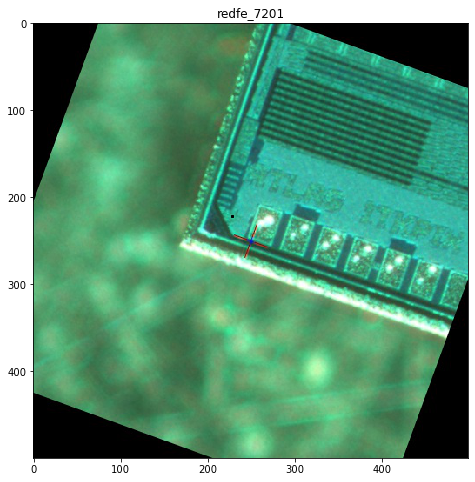

In [23]:
plot_image("/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe_onlyrot/redfe_7201.jpg","/mnt/project_mnt/atlas/atlas_gen_fs/vannolil/triplets_cnn/data/redfe_label_onlyrot/redfe_cross_center_coords_7201.npy")

In [ ]:
print(num_files = len([f for f in os.listdir(output_label_dir) if os.path.isfile(os.path.join(output_label_dir, f))]))